In [1]:
import pandas as pd
import torch
import json
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from utils.utils_train import train_supervised, train_models_in_threads, test_model_in_batches
from utils.utils_plots import plot_interesting_features, plot_metric_data, save_figure, plot_cluster_data
from utils.utils_dataset import balance_dataset, prepare_dataset, balance_data_for_clients
from utils.utils_dataset import display_dataset_split
from utils.utils_metrics import calculate_metrics, plot_confusion_matrix, calculate_roc_auc


In [2]:
from model.eGauss_plus import eGAUSSp

In [3]:
# Load the dataset
file_path = 'Datasets/creditcard.csv'
data = pd.read_csv(file_path)
feature_dim = 29

# Remove the first dimension/column
data = data.drop(data.columns[0], axis=1)

# Compute the ranges
ranges = data.max() - data.min()

# Display the ranges
print(ranges)

'''
# Initialize the StandardScaler
scaler = StandardScaler()

# Select the columns to normalize - all except 'Class'
cols_to_normalize = [col for col in data.columns if col != 'Class']

# Apply the normalization
data[cols_to_normalize] = scaler.fit_transform(data[cols_to_normalize])

# Set the number of PCA components
feature_dim = 10  # Change this value to adjust the number of components

# Initialize PCA
pca = PCA(n_components=feature_dim)

# Apply PCA to the normalized data
# Note that we don't apply PCA to the 'Class' column
pca_data = pca.fit_transform(data[cols_to_normalize])

# Create a DataFrame with PCA results and the 'Class' column
pca_columns = ['PC' + str(i+1) for i in range(feature_dim)]
pca_data_df = pd.DataFrame(pca_data, columns=pca_columns)
pca_data_df['Class'] = data['Class']

data = pca_data_df
'''

V1           58.862440
V2           94.773457
V3           57.708148
V4           22.558515
V5          148.544973
V6           99.462131
V7          164.146736
V8           93.223927
V9           29.029061
V10          48.333399
V11          16.816387
V12          26.532107
V13          12.918764
V14          29.741092
V15          13.376686
V16          31.444966
V17          34.416326
V18          14.539815
V19          12.805499
V20          93.918625
V21          62.033221
V22          21.436234
V23          67.336147
V24           7.421176
V25          17.814986
V26           6.121896
V27          54.177877
V28          49.277892
Amount    25691.160000
Class         1.000000
dtype: float64


"\n# Initialize the StandardScaler\nscaler = StandardScaler()\n\n# Select the columns to normalize - all except 'Class'\ncols_to_normalize = [col for col in data.columns if col != 'Class']\n\n# Apply the normalization\ndata[cols_to_normalize] = scaler.fit_transform(data[cols_to_normalize])\n\n# Set the number of PCA components\nfeature_dim = 10  # Change this value to adjust the number of components\n\n# Initialize PCA\npca = PCA(n_components=feature_dim)\n\n# Apply PCA to the normalized data\n# Note that we don't apply PCA to the 'Class' column\npca_data = pca.fit_transform(data[cols_to_normalize])\n\n# Create a DataFrame with PCA results and the 'Class' column\npca_columns = ['PC' + str(i+1) for i in range(feature_dim)]\npca_data_df = pd.DataFrame(pca_data, columns=pca_columns)\npca_data_df['Class'] = data['Class']\n\ndata = pca_data_df\n"

In [4]:
print(f"{torch.cuda.is_available()}")
device = torch.device("cpu") #torch.device("cuda" if torch.cuda.is_available() else "cpu") #torch.device("cpu") #

False


In [5]:
import itertools
import matplotlib.pyplot as plt
#import plotly.graph_objs as go
import pandas as pd
import concurrent.futures
import threading  # Import the threading module

if 0:

    num_clients = 1

    # Define the range of values for each parameter
    num_sigma_values = [5, 10, 15, 20]
    kappa_join_values = [0.3, 0.5, 0.8]
    N_r_values = [10, 20, 30]

    # Total number of experiments
    total_experiments = len(num_sigma_values) * len(kappa_join_values) * len(N_r_values)
    completed_experiments = 0

    # Define other parameters and data setup
    local_model_params = {
        "feature_dim": feature_dim,
        "num_classes": 2,
        "kappa_n": 1,
        "S_0": 1e-10,
        "c_max": 100,
        "num_samples": 200, 
        "device": device  # Make sure 'device' is defined
    }

    # Placeholder for the best parameters and best score
    best_params = None
    best_score = 0

    # List to store all results
    results = []

    # Function to write data to a file
    def write_to_file(file_path, data, mode='a'):
        with open(file_path, mode) as file:
            file.write(data + "\n")

    # Prepare the dataset
    # Assuming prepare_dataset function and data are defined
    X = data.iloc[:, :-1].values
    y = data.iloc[:, -1].values
    client_train_unbalanced, test_data, all_data = prepare_dataset(X, y, num_clients)
    client_train = balance_data_for_clients(client_raw_data=client_train_unbalanced, balance=["random"], local_models=None, round=1)
    
    # Initialize a lock and a shared variable for progress tracking
    lock = threading.Lock()
    completed_experiments = 0
    total_experiments = len(num_sigma_values) * len(kappa_join_values) * len(N_r_values)

    # Function to execute model training and evaluation
    def train_evaluate_model(params):
        global completed_experiments
        
        num_sigma, kappa_join, N_r = params
        local_model_params.update({"num_sigma": num_sigma, "kappa_join": kappa_join, "N_r": N_r})

        local_model = eGAUSSp(**local_model_params)
        train_supervised(local_model, client_train[0])

        _, pred_max, _ = test_model_in_batches(local_model, test_data, batch_size = 1000)
        metrics = calculate_metrics(pred_max, test_data, weight="binary")

        result_str = f"num_sigma:{num_sigma}, kappa_join:{kappa_join}, N_r:{N_r}, f1_score:{metrics['f1_score']}, precission:{metrics['precision']}, recall:{metrics['recall']}"
        print(result_str)
        write_to_file("experiment_results.txt", result_str)  # Write results to file
        
        # Update progress
        with lock:
            completed_experiments += 1
            progress = (completed_experiments / total_experiments) * 100
            print(f"Progress: {completed_experiments}/{total_experiments} ({progress:.2f}%)")

        return {"num_sigma": num_sigma, "kappa_join": kappa_join, "N_r": N_r, "f1_score": metrics["f1_score"], "precission": metrics["precision"], "recall": metrics["recall"]}
        

    # Write initial setup data to file
    initial_setup_str = f"Initial Setup: num_clients={num_clients}, num_sigma_values={num_sigma_values}, kappa_join_values={kappa_join_values}, N_r_values={N_r_values}"
    write_to_file("experiment_results.txt", initial_setup_str, mode='w')  # 'w' to overwrite if exists

    # Using ThreadPoolExecutor to run in multiple threads
    with concurrent.futures.ThreadPoolExecutor() as executor:
        param_combinations = list(itertools.product(num_sigma_values, kappa_join_values, N_r_values))
        results = list(executor.map(train_evaluate_model, param_combinations))

    results_df = pd.DataFrame(results)


In [6]:

#display_dataset_split(client_train, test_data)
#plot_dataset_split(client_train, test_data)

In [7]:
def compare_models(model1, model2):
    differences = []

    # Function to find differing indices within the overlapping range
    def find_differing_indices(tensor1, tensor2):
        min_length = min(tensor1.size(0), tensor2.size(0))
        differing = (tensor1[:min_length] != tensor2[:min_length]).nonzero(as_tuple=False)
        if differing.nelement() == 0:
            return "No differences"
        else:
            return differing.view(-1).tolist()  # Flatten and convert to list

    # Compare mu parameter and find differing indices
    mu_equal = torch.equal(model1.mu[:model1.c], model2.mu[:model2.c])
    if not mu_equal:
        differing_indices_mu = find_differing_indices(model1.mu[:model1.c], model2.mu[:model2.c])
        differences.append(f"mu parameter differs at indices {differing_indices_mu}")

    # Compare S parameter and find differing indices
    S_equal = torch.equal(model1.S[:model1.c], model2.S[:model2.c])
    if not S_equal:
        differing_indices_S = find_differing_indices(model1.S[:model1.c], model2.S[:model2.c])
        differences.append(f"S parameter differs at indices {differing_indices_S}")

    # Compare n parameter and find differing indices
    n_equal = torch.equal(model1.n[:model1.c], model2.n[:model2.c])
    if not n_equal:
        differing_indices_n = find_differing_indices(model1.n[:model1.c], model2.n[:model2.c])
        differences.append(f"n parameter differs at indices {differing_indices_n}")

    # Check if there are any differences
    if differences:
        difference_str = ", ".join(differences)
        return False, f"Differences found in: {difference_str}"
    else:
        return True, "Models are identical"


In [8]:
def write_to_file(file_path, data, mode='a'):
    with open(file_path, mode) as file:
        file.write(data + "\n")

In [9]:

def run_individual_experiment(federated_model_params, local_model_params, num_clients, num_rounds, client_raw_train, test_data, balance_techniques, test_clients=True):

    #local_model_params["c_max"] = int(federated_model_params["c_max"]/num_clients)

    # Initialize a model for each client
    local_models = [eGAUSSp(**local_model_params) for _ in range(num_clients)]
    federated_model = eGAUSSp(**federated_model_params)

    # Initialize a list to store the metrics for each round
    round_metrics = []
    result_file = "experiment_results.txt"
    client_train = []
    for round in range(num_rounds):
        print(f"--- Communication Round {round + 1} ---")
        round_info = f"--- Communication Round {round + 1} ---\n"

        client_train = balance_data_for_clients(client_raw_data=client_raw_train, balance_techniques=balance_techniques, local_models=local_models, round=round)
        display_dataset_split(client_train, test_data)
        
        #aggregated_model = eGAUSSp(**federated_model_params)
        federated_model = eGAUSSp(**federated_model_params)

        # Train local models
        train_models_in_threads(local_models, client_train)

        '''
        for local_model, client_data in zip(local_models, clients_data):
             train_supervised(local_model, client_data)

             print(f"Number of local model clusters = {sum(local_model.n[0:local_model.c]> local_model.kappa_n)}")
        '''   

        # Update federated model with local models
        for client_idx, _ in enumerate(local_models):

            print(f"Number of local model clusters = {sum(local_models[client_idx].n[0:local_models[client_idx].c]> 0)}")
            # Run the forward function on the training data
            
            #local_models[client_idx].federal_agent.federated_merging()
            
            if test_clients:
                # Calculate and collect metrics for each client model
                _, client_pred, _ = test_model_in_batches(local_models[client_idx], client_train[client_idx], batch_size=500)
                client_binary = calculate_metrics(client_pred, client_train[client_idx], "binary")
                
                print(f"Train Metrics: {client_binary}")
            # plot_confusion_matrix(pred_max, clients_data[client_idx])

            print(f"Updating agreggated model with client {client_idx + 1}")

            federated_model.federal_agent.merge_model_privately(local_models[client_idx], local_models[client_idx].kappa_n, pred_min = 0)
            
        print(f"Agreggated clusters after transfer = {sum(federated_model.n[0:federated_model.c]> federated_model.kappa_n)}")

        #local_models = [eGAUSSp(**local_model_params) for _ in range(num_clients)] 

        print("\n")
        
        # Perform federated merging and removal mechanism on the federated model
        # Evaluate federated model
        agg_clusters = []
        agg_binary = []
        if test_clients:
            agg_scores, agg_pred, _ = test_model_in_batches(federated_model, test_data, batch_size=1000)
            agg_binary = calculate_metrics(agg_pred, test_data, "binary")
            agg_clusters = sum(federated_model.n[0:federated_model.c].cpu() > federated_model.kappa_n)
            print(f"Aggregated Metrics: {agg_binary}")

        federated_model.federal_agent.federated_merging()
        print(f"Federated clusters after merging = {sum(federated_model.n[0:federated_model.c]> federated_model.kappa_n)}")
    
        # Evaluate federated model
        fed_scores, fed_pred, _ = test_model_in_batches(federated_model, test_data, batch_size=1000)
        fed_binary = calculate_metrics(fed_pred, test_data, "binary")
        fed_roc_auc = calculate_roc_auc(fed_scores, test_data)
        print(f"Test Metrics: {fed_binary}")
        print(f"Test ROC AUC: {fed_roc_auc}")
        
        #plot_confusion_matrix(pred_max_fed, test_data)

        print("\n")
 
        # Return the updated federated model to each client
        client_metrics = [] # Reset client metrics for the new round
        for client_idx, _ in enumerate(local_models):
            print(f"Returning updated model to client {client_idx + 1}")

            local_models[client_idx].federal_agent.merge_model_privately(federated_model, federated_model.kappa_n, pred_min = 0)
            local_models[client_idx].federal_agent.federated_merging()
            print(f"Number of local model clusters after transfer = {sum(local_models[client_idx].n[0:local_models[client_idx].c]> 0)}")

            if test_clients:
                # Calculate and collect metrics for each client model
                _, client_pred, _ = test_model_in_batches(local_models[client_idx], test_data, batch_size=500)
                client_binary = calculate_metrics(client_pred, test_data, "binary")

                print(f"Test Metrics client {client_idx} after merge: {client_binary}")
                # plot_confusion_matrix(pred_max, clients_data[client_idx])
                
                # Calculate additional metrics for each client
                client_metrics.append({
                    'client_idx': client_idx,
                    'binary': client_binary,
                    'clusters': sum(local_models[client_idx].n[0:local_models[client_idx].c].cpu()> 0)
                })
            
            #local_models[client_idx].score = torch.ones_like(local_models[client_idx].score)
            local_models[client_idx].num_pred = torch.zeros_like(local_models[client_idx].num_pred)
            
          # Print and write round information to file
        round_info = f"--- End of Round {round + 1} ---\n"
        print(round_info)
        #write_to_file(result_file, round_info)

        round_metrics.append({
            'round': round + 1,
            'federated_model': {
                'clusters': sum(federated_model.n[0:federated_model.c].cpu() > federated_model.kappa_n),
                'binary': fed_binary,
                'roc_auc': fed_roc_auc
            },
            'aggregated_model': {
                'clusters': agg_clusters,
                'binary': agg_binary,
            },
            'client_metrics': client_metrics
        })
        
        
        # Plot features for the current round
        plt.close('all')  # Close all existing plots to free up memory
        if  False:
            #fig1 = plot_interesting_features(client_train[0], model=federated_model, num_sigma=federated_model.num_sigma, N_max=federated_model.kappa_n)   
            #save_figure(fig1, "./Images/credit_fraud_clusters", format='pdf')
            fig2 = plot_interesting_features(client_train[0], model=federated_model, num_sigma=2, N_max=federated_model.kappa_n)   
            save_figure(fig2, ".Images/credit_fraud_samples.pdf", format='pdf')

        # Iterate over each round's metrics and write to file
        for metric in round_metrics:
            metric_info = f"Round {metric['round']}: Metrics: {metric['federated_model']['binary']}, ROC AUC: {metric['federated_model']['roc_auc']}\n"
            print(metric_info)  # Print each round's metrics
            try:
                write_to_file(result_file, metric_info)  # Write to file
            except:
                print("Could not write to file.")
                pass

    # After all rounds
    final_info = "All Rounds Completed. Metrics Collected:\n"
    print(final_info)
    #write_to_file(result_file, final_info)

    # Iterate over each round's metrics and write to file
    for metric in round_metrics:
        metric_info = f"Round {metric['round']}: "
        metric_info += f"Federated Model - Clusters: {metric['federated_model']['clusters']}, "
        metric_info += f"Binary Metrics: {metric['federated_model']['binary']}, ROC AUC: {metric['federated_model']['roc_auc']}\n"
        metric_info += f"Aggregated Model - Clusters: {metric['aggregated_model']['clusters']}\n"

        for client_metric in metric['client_metrics']:
            metric_info += f"Client {client_metric['client_idx']} - Binary: {client_metric['binary']}\n"

        print(metric_info)  # Print each round's metrics
        #write_to_file(result_file, metric_info)  # Write to file

    return round_metrics


In [10]:
# Define the range of values for each parameter
num_sigma_values = [10, 15, 20]
kappa_join_values = [0.3, 0.4, 0.5, 0.8, 1, 2]
N_r_values = [15, 20, 25, 30]
proportion = [5, 3, 1]

federated_model_params = {
    "feature_dim": feature_dim,
    "num_classes": 2,
    "kappa_n": 1,
    "num_sigma": 10,
    "kappa_join": 0.8,
    "S_0": 1e-10,
    "N_r": 30,
    "c_max": 300, #local_model_params["c_max"]*num_clients,
    "num_samples": 1,
    "device": device
}

    # Model parameters
local_model_params = {
    "feature_dim": feature_dim,
    "num_classes": 2,
    "kappa_n": 1,
    "num_sigma": 0,
    "kappa_join": 0,
    "S_0": 1e-10,
    "N_r": 0,
    "c_max": 300,
    "num_samples": 1,
    "device": device
}

# List of client counts and data configuration indices
client_counts = [3]
data_config_indices = [1]  # Replace with your actual data configuration indices

# Assuming local_models, client_train, federated_model, and test_data are already defined
# Number of communication rounds
num_rounds = 5

In [11]:
import os

def run_experiments(data, client_counts, data_config, federated_model_params, local_model_params, num_rounds, proportion, flag_profiler=False, flag_test_clients=False):
    experiments = []
    results_dir = ".Results"  # Directory to save the results
    os.makedirs(results_dir, exist_ok=True)  # Create the directory if it doesn't exist

    print(f'\n *** Experiment details ***:\n' 
        f'  - Number of Clients: {max(client_counts)}\n' 
        f'  - Number of Rounds: {num_rounds}\n'
        f'  - Data dristribution proportions: {proportion}\n'
        f'  - num_sigma Parameter: {federated_model_params["num_sigma"]}\n'
        f'  - kappa_join Parameter: {federated_model_params["kappa_join"]}\n'
        f'  - N_r Parameter: {federated_model_params["N_r"]}')
   
    for num_clients in client_counts:
        for data_config_index in data_config:
            X = data.iloc[:, :-1].values
            y = data.iloc[:, -1].values
            client_raw_train, test_data, all_data = prepare_dataset(X, y, num_clients)

            balance_techniques = None
            if data_config_index == 1:
                balance_techniques = ['random'] * int(proportion)
            elif data_config_index == 2:
                balance_techniques = 'Smote'

            print(f"Running experiment with {num_clients} clients and data configuration {data_config_index}")
            
            if flag_profiler:
                # Import profiling packages only if profiler is True
                import cProfile
                import yappi
                try:
                    # Try to load the memory_profiler extension if it's available
                    get_ipython().run_line_magic('load_ext', 'memory_profiler')
                except:
                    print("Memory profiler not available.")

                print(f"... with profiler")
                pr = cProfile.Profile()
                pr.enable()
                yappi.start()
                
                metrics = run_individual_experiment(federated_model_params=federated_model_params, 
                                                    local_model_params=local_model_params, 
                                                    num_clients=num_clients, num_rounds=num_rounds, 
                                                    client_raw_train=client_raw_train, test_data=test_data,
                                                    balance_techniques=balance_techniques, test_clients=flag_test_clients)
                
                yappi.stop()
                pr.disable()

                pr.print_stats(sort='cumtime')
                yappi.get_thread_stats().print_all()
                yappi.get_func_stats().print_all()
            else:
                metrics = run_individual_experiment(federated_model_params=federated_model_params, 
                                                    local_model_params=local_model_params, 
                                                        num_clients=num_clients, num_rounds=num_rounds, 
                                                    client_raw_train=client_raw_train, test_data=test_data,
                                                    balance_techniques=balance_techniques, test_clients=flag_test_clients)

            experiments.append((f"num_clients_{num_clients}_sampling_{data_config_index}", metrics))

            # Construct a specific name for the saved file
            file_name = f'experiment_metrics_num_clients_{max(client_counts)}_rounds_{num_rounds}_proportions_{proportion}_num_sigma_{federated_model_params["num_sigma"]}_kappa_join_{int(federated_model_params["kappa_join"]*10)}_N_r_{federated_model_params["N_r"]}.pth'
            file_path = os.path.join(results_dir, file_name)

            # Save the experiments
            torch.save(experiments, file_path)
            print(f"Saved experiments to {file_path}")
            return experiments

In [12]:

def evaluate_metric(experiments, round_number):
    # Assuming the experiments list contains the metrics for each experiment
    # and each experiment's metrics contain the F1 score for the federated model
    for experiment in experiments:
        if experiment[1][-1]['round'] == int(round_number): #[1] is the experiment values, [0] is the name of the experiment, [-1] is the last round
            # Assuming 'binary' key contains a dictionary where 'f1_score' is one of the keys
            return experiment[1][-1]['federated_model']['binary']['f1_score']
    return None

def run_parameterized_experiments(data, client_counts, data_config, num_rounds):
    best_setting = None
    best_f1_score = -float('inf')
    all_experiments_metrics = []

    for num_sigma in num_sigma_values:
        for kappa_join in kappa_join_values:
            for N_r in N_r_values:
                for prop in proportion:

                    
                    # Update the model parameters
                    federated_model_params.update({"num_sigma": num_sigma, "kappa_join": kappa_join, "N_r": N_r})
                    local_model_params.update({"num_sigma": num_sigma, "kappa_join": kappa_join, "N_r": N_r})

                    # Run the experiment
                    experiments = run_experiments(
                        data=data,
                        client_counts=client_counts,
                        data_config=data_config_indices, 
                        federated_model_params=federated_model_params, 
                        local_model_params=local_model_params, 
                        num_rounds=num_rounds, 
                        proportion=prop, 
                        flag_profiler= False,
                        flag_test_clients = False)


                    # Store all experiments' metrics
                    all_experiments_metrics.append(experiments)

                    # Evaluate the F1 score of the 5th round
                    f1_score = evaluate_metric(experiments, num_rounds)
                    
                    # Update the best setting if current setting's F1 score is better
                    if f1_score and f1_score > best_f1_score:
                        best_f1_score = f1_score
                        best_setting = (num_sigma, kappa_join, N_r, prop)

    return best_setting, best_f1_score, all_experiments_metrics

In [13]:
from matplotlib.pyplot import flag

flag_full_experiment = 0

if flag_full_experiment:
    
    #THIS CODE RUNS THE EXPERIMENTS FOR MULTIPLE SETTING TO DETERMINE THE BEST
    best_setting, best_f1_score, all_experiments_metrics = run_parameterized_experiments(data, client_counts, data_config_indices, num_rounds)
    print("Best Setting:", best_setting)
    print("Best F1 Score:", best_f1_score)

    # Save the best setting and all experiments' metrics
    torch.save({
        "best_setting": best_setting,
        "best_f1_score": best_f1_score,
        "experiments_metrics": all_experiments_metrics
    }, 'experiment_results.pth')


In [14]:
federated_model_params = {
    "feature_dim": feature_dim,
    "num_classes": 2,
    "kappa_n": 1,
    "num_sigma": 15,
    "kappa_join": 0.4,
    "S_0": 1e-10,
    "N_r": 30,
    "c_max": 30, #local_model_params["c_max"]*num_clients,
    "num_samples": 1,
    "device": device
}

    # Model parameters
local_model_params = {
    "feature_dim": feature_dim,
    "num_classes": 2,
    "kappa_n": 1,
    "num_sigma": 15,
    "kappa_join": 0.4,
    "S_0": 1e-10,
    "N_r": 30,
    "c_max": 30,
    "num_samples": 1,
    "device": device
}

# List of client counts and data configuration indices
client_counts = [3]
data_config_indices = [1]  # Replace with your actual data configuration indices

# Assuming local_models, client_train, federated_model, and test_data are already defined
# Number of communication rounds
num_rounds = 30

proportion = 1

if flag_full_experiment:
    # Update the model parameters with the best setting
    federated_model_params.update({
        "num_sigma": best_setting[0],
        "kappa_join": best_setting[1],
        "N_r": best_setting[2]
    })

    local_model_params.update({
        "num_sigma": best_setting[0],
        "kappa_join": best_setting[1],
        "N_r": best_setting[2]
    })

    # Set the number of rounds and proportion with the best setting
    proportion = best_setting[3]

else:
    pass

# Run the experiments with the best setting for 30 rounds
experiments = run_experiments(
            data=data, 
            client_counts=client_counts,
            data_config=data_config_indices, 
            federated_model_params=federated_model_params, 
            local_model_params=local_model_params, 
            num_rounds=num_rounds, 
            proportion=proportion, 
            flag_profiler=False,
            flag_test_clients = True)



 *** Experiment details ***:
  - Number of Clients: 3
  - Number of Rounds: 30
  - Data dristribution proportions: 1
  - num_sigma Parameter: 15
  - kappa_join Parameter: 0.4
  - N_r Parameter: 30
Running experiment with 3 clients and data configuration 1
--- Communication Round 1 ---
Client 1: {0: 132, 1: 132}
Client 2: {0: 131, 1: 131}
Client 3: {0: 131, 1: 131}
Test Set: {0: 56864, 1: 98}

Combined Number of Samples per Class:
Class 0: 57258 samples
Class 1: 492 samples

Total Number of Samples Across All Datasets: 57750
Debugging has been disabled.
Evolving has been enabled.
Debugging has been disabled.
Evolving has been enabled.
Debugging has been disabled.
Evolving has been enabled.
Number of local model clusters = 139
Evolving has been disabled.
Train Metrics: {'accuracy': 1.0, 'precision': 1.0, 'recall': 1.0, 'f1_score': 1.0}
Updating agreggated model with client 1
Updated var_glo values: tensor(25.9288)
Number of local model clusters = 127
Evolving has been disabled.
Train Me

c:\Users\mihao\OneDrive - Univerza v Ljubljani\Doktorski_studij\Delo\eGAUSSp_Python\.conda\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Metrics client 0 after merge: {'accuracy': 0.9982795547909132, 'precision': 0.0, 'recall': 0.0, 'f1_score': 0.0}
Returning updated model to client 2
Updated var_glo values: tensor(nan)
Number of local model clusters after transfer = 300
Evolving has been disabled.
Test Metrics client 1 after merge: {'accuracy': 0.0017204452090867595, 'precision': 0.0017204452090867595, 'recall': 1.0, 'f1_score': 0.0034349807220469685}
Returning updated model to client 3
Updated var_glo values: tensor(nan)
Number of local model clusters after transfer = 300
Evolving has been disabled.
Test Metrics client 2 after merge: {'accuracy': 0.0017204452090867595, 'precision': 0.0017204452090867595, 'recall': 1.0, 'f1_score': 0.0034349807220469685}
--- End of Round 30 ---

Round 1: Metrics: {'accuracy': 0.9867279941013307, 'precision': 0.09681372549019608, 'recall': 0.8061224489795918, 'f1_score': 0.1728665207877462}, ROC AUC: 0.9778404327403443

Round 2: Metrics: {'accuracy': 0.9871668831852815, 'precision'

In [20]:
experiments = torch.load('.Results/experiment_metrics_num_clients_3_rounds_30_proportions_1_num_sigma_15_kappa_join_4_N_r_30_good.pth')

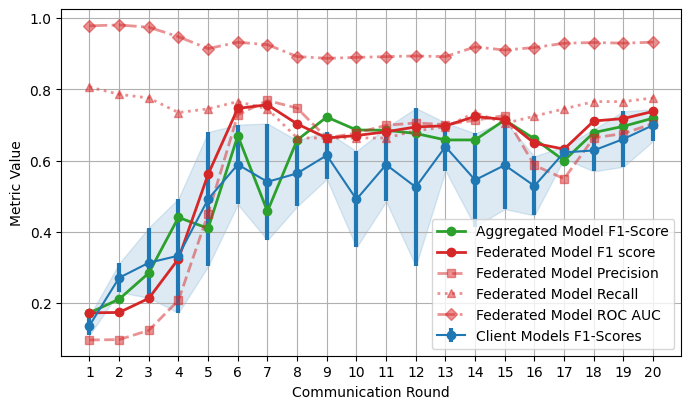

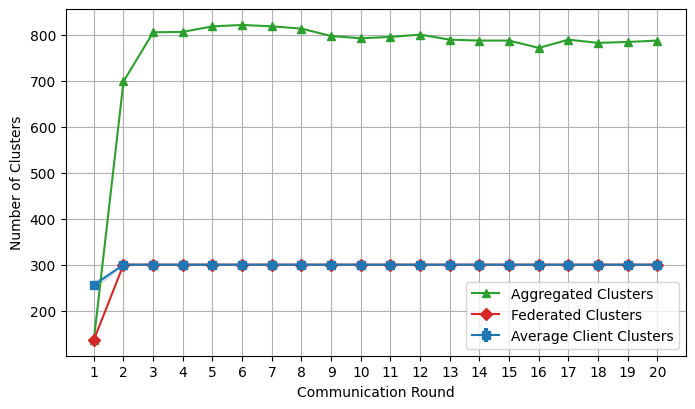

Figure saved as .Images/credit_fraud_metrics_num_clients_3_sampling_1.pdf in pdf format.
Figure saved as .Images/credit_fraud_clusters_num_clients_3_sampling_1.pdf in pdf format.


In [24]:
max_rounds = 20

figs_metrics = []
figs_clusters = []
experiment_name = []
for exp_num, (name, metrics) in enumerate(experiments):
    
    if max_rounds is not None:
        metrics = metrics[:max_rounds]
    rounds = [m['round'] for m in metrics]

    
    # Plot and collect figures
    legend = True if exp_num == 0 else False
    experiment_name.append(name)
    
    figs_metrics.append(plot_metric_data(metrics, ['f1_score', 'precision', 'recall'], rounds, f'Experiment {exp_num+1} - Metrics', legend=legend))
    figs_clusters.append(plot_cluster_data(metrics, rounds, legend=legend))

# Save figures from fig_metrics
for i, figure in enumerate(figs_metrics):
    save_path = f".Images/credit_fraud_metrics_{experiment_name[i]}.pdf"
    save_figure(figure, save_path, "pdf")

# Save figures from fig_clusters
for i, figure in enumerate(figs_clusters):
    save_path = f".Images/credit_fraud_clusters_{experiment_name[i]}.pdf"
    save_figure(figure, save_path, "pdf")

In [52]:


max_rounds = 20

# Assuming metrics contains values for precision, recall, f1_score, and roc_auc
data_rows = []
for exp_num, (name, metrics) in enumerate(experiments):
    if max_rounds is not None:
        metrics = metrics[:max_rounds]

    num_clients = len(metrics[-1]["client_metrics"])
    
    # Extract relevant metrics. Assuming the metrics list has dictionaries with the required keys
    # Adjust the keys according to your metrics structure
    precision = metrics[-1][ 'federated_model']['binary'].get('precision', '-')
    recall = metrics[-1][ 'federated_model']['binary'].get('recall', '-')
    f1_score = metrics[-1][ 'federated_model']['binary'].get('f1_score', '-')
    roc_auc = metrics[-1][ 'federated_model'].get('roc_auc', '-')

    # Format the data row for LaTeX
    data_rows.append(f"Random 1:1 & ${(100*precision):.0f}$"+r"\% & " + f"-" f"& ${(100*recall):.0f}$" +r"\% & " + f"-" + f"& ${(100*f1_score):.0f}$" + r"\% & "+ f"-" + f"& ${(100*roc_auc):.0f}$"+r"\% & - \\\\")

# LaTeX Table
header = r'''
\begin{table}[ht]
\centering
\setlength{\tabcolsep}{3pt}
\scriptsize
\caption{Results of the Credit Card Fraud Detection}
\begin{tabular}{lcccccccc}
\toprule
Dataset & \multicolumn{2}{c}{Precision$\uparrow$} & \multicolumn{2}{c}{Recall$\uparrow$} & \multicolumn{2}{c}{F1 Score$\uparrow$} & \multicolumn{2}{c}{ROC AUC$\uparrow$} \\
\cmidrule(lr){2-3} \cmidrule(lr){4-5} \cmidrule(lr){6-7} \cmidrule(lr){8-9}
& 3 & 10 & 3 & 10 & 3 & 10 & 3 & 10 \\
\midrule
'''

# Concatenate all data rows
data = "\n".join(data_rows)

# End of the table
footer = r'''
\bottomrule
\end{tabular}
\label{tab:credit_fraud}
\end{table}
'''

# Complete table
latex_table = header + data + footer

print(latex_table)



\begin{table}[ht]
\centering
\setlength{\tabcolsep}{3pt}
\scriptsize
\caption{Results of the Credit Card Fraud Detection}
\begin{tabular}{lcccccccc}
\toprule
Dataset & \multicolumn{2}{c}{Precision$\uparrow$} & \multicolumn{2}{c}{Recall$\uparrow$} & \multicolumn{2}{c}{F1 Score$\uparrow$} & \multicolumn{2}{c}{ROC AUC$\uparrow$} \\
\cmidrule(lr){2-3} \cmidrule(lr){4-5} \cmidrule(lr){6-7} \cmidrule(lr){8-9}
& 3 & 10 & 3 & 10 & 3 & 10 & 3 & 10 \\
\midrule
Random 1:1 & $70$\%+ & -& $78$\% & -& $74$\% & -& $93$\% & - \\\\
\bottomrule
\end{tabular}
\label{tab:credit_fraud}
\end{table}

